In [371]:
import scqubits as scqubits
import autograd.numpy as anp
from autograd import grad, jacobian
import scipy.optimize as optimize
import scipy.linalg as linalg
import qutip as qt
import matplotlib.pyplot as plt
from cosmatrix import cosm
from autograd.extend import primitive, defvjp
import os
import dynamiqs as dq
from swt import swt_subspace

# Disable multi-threading to avoid issues with fork
os.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=1"
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Disable GPU if present




class Hamiltonian:
    def __init__(self, phi_ex, Ej, Ec, bare_dim, trunc_dim, omega_c1, omega_c2, phizpf_dependence = True, twolevelapp = False):
        self.phi_ex = phi_ex
        self.Ej = Ej * 2*anp.pi
        self.Ec = Ec * 2*anp.pi
        self.beta = 1
        self.N = 1
        self.original_dim = bare_dim
        self.trunc_dim = trunc_dim
        self.sdim, self.c2dim, self.c1dim = bare_dim
        self.total_dim = self.sdim*self.c2dim*self.c1dim
        self.omega_c1 = omega_c1
        self.omega_c2 = omega_c2
        self.phizpf_dependence = phizpf_dependence
        self.twolevelapp = twolevelapp
        self.g = 0.05*2*anp.pi
        self.option = dq.Options(progress_meter=None)
        self.H , self.H_control = self.get_H()
        self.H_dressed, self.H_control_dressed = self.dressed_basis()
        

    def sort_eigenpairs(self, eigenvalues, eigenvectors):
        n = eigenvectors.shape[0]
        sorted_indices = []

        for i in range(n):
            max_abs_vals = anp.abs(eigenvectors[i, :])
            remaining_indices = [j for j in range(len(max_abs_vals)) if j not in sorted_indices]
            max_index = remaining_indices[anp.argmax(max_abs_vals[remaining_indices])]
            sorted_indices.append(max_index)

        sorted_indices_array = anp.array(sorted_indices)
        sorted_eigenvalues = eigenvalues[sorted_indices_array]
        sorted_eigenvectors = eigenvectors[:, sorted_indices_array]
        return sorted_eigenvalues, sorted_eigenvectors
    
    def state_index(self, index,dim):
        n,k,m = index
        N,K,M = dim
        return n*K*M + k*M + m
    
    def get_indices(self, trunc):
        """
        Convert a list of 3D indices to 1D indices based on given dimensions.
        indecies follow (squid, cavity2, cavity1)
        
        Args:
            trunc: List of three integers [N,K,M] specifying the dimensions to include
                 N is number of SNAIL states
                 K is number of cavity 2 states
                 M is number of cavity 1 states
                 
        Returns:
            List of 1D indices corresponding to the 3D indices
        """
        N, K, M = trunc
        indices_1d = []
        
        # Generate all 3D indices and store indices outside truncation
        for n in range(self.sdim):
            for k in range(self.c2dim):
                for m in range(self.c1dim):
                    # Only add indices that are outside the truncation
                    if n >= N or k >= K or m >= M:
                        index = [n,k,m]
                    
                        # Convert to 1D index using state_index method
                        idx = self.state_index(index, self.original_dim)
                        indices_1d.append(idx)
        return indices_1d
        
    def remove_row_col(self, matrix, indices):
        # Check if matrix is square
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError("Input matrix must be square")
        
        # Convert single index to list if needed
        if isinstance(indices, (int, anp.integer)):
            indices = [indices]
            
        # Convert to list if numpy array
        if isinstance(indices, anp.ndarray):
            indices = indices.tolist()
            
        # Sort indices in descending order to avoid changing indices when deleting
        indices = sorted(indices, reverse=True)
        
        # Check if indices are valid
        if any(i < 0 or i >= matrix.shape[0] for i in indices):
            raise ValueError(f"All indices must be between 0 and {matrix.shape[0]-1}")
        
        # Remove rows and columns
        # Don't use copy as it breaks autograd's gradient tracking
        result = matrix  # Start with the original matrix
        # anp.delete is not compatible with autograd, so we need to implement
        # row/column deletion manually using slicing and concatenation
        for idx in indices:
            # Remove row
            if idx > 0:
                result = anp.concatenate((result[:idx], result[idx+1:]), axis=0)
            else:
                result = result[1:]
                
            # Remove column
            if idx > 0:
                result = anp.concatenate((result[:, :idx], result[:, idx+1:]), axis=1)
            else:
                result = result[:, 1:]
        return result
    
    def truncate_matrix(self, matrix, trunc):
        indices = self.get_indices(trunc)
        return self.remove_row_col(matrix, indices)
    
    def annihilation(self, dim):
        return anp.diag(anp.sqrt(anp.arange(1,dim)),1)
    def creation(self, dim):
        return anp.diag(anp.sqrt(anp.arange(1,dim)),-1)
    def tensor_product(self,A,B,C):
        return anp.kron(A,anp.kron(B,C))
    
    def SNAIL(self):
        """
        This function starts from SNAIL hamiltonian in oscillator basis,  and then calculates the SNAIL Hamiltonian and returns the Hamiltonian and the charge operator in eigenbasis. 
        returns: Hs, charge_op in eigenbasis
        """
        beta = self.beta
        N = self.N
        Ej = self.Ej
        Ec = self.Ec
        phi_ex = self.phi_ex*2*anp.pi
        sdim = 20
        # Find minimum of SNAIL potential using autograd primitive
        @primitive
        def Us_min(phi_ex):
            def U_s(phi): 
                return (-beta*anp.cos(phi-phi_ex)-N*anp.cos((phi)/N))
            phi_min = optimize.minimize(U_s, anp.array([0.])).x
            return phi_min
        
        def phi_minde(ans, phi_ex):
            def phi_minde_vjp(g):
                c2 = beta*anp.cos(ans - phi_ex) + 1/N*anp.cos(ans/N)
                return g*beta*anp.cos(ans - phi_ex)/c2
            return phi_minde_vjp
        defvjp(Us_min, phi_minde)
        
        phi_min = Us_min(phi_ex)
        # potential expansion around minimum
        c2 = beta*anp.cos(phi_min - phi_ex) + 1/N*anp.cos(phi_min/N)
        omega_s = anp.sqrt(8*c2*Ej*Ec)
        if self.phizpf_dependence == True:
            phi_zpf = anp.power(2*Ec/(Ej*c2),1/4)
        else:
            phi_zpf = anp.power(2*Ec/(Ej*c2),1/4)
        self.phi_zpf = phi_zpf
        g2 = Ej*phi_zpf**2*c2/2
        s = self.annihilation(sdim)
        sd = self.creation(sdim)
        x2 = anp.matmul(s+sd,s+sd)
        Hs =( omega_s * anp.matmul(sd,s)
            - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*anp.identity(sdim))
            + N*cosm((phi_zpf*(s+sd)+phi_min*anp.identity(sdim))/N))- g2*x2)
        Hs = anp.real(Hs)
        charge_op = -1j*(s-sd)/2/phi_zpf
        energy0,U = anp.linalg.eigh(Hs)
        energy0,U = self.sort_eigenpairs(energy0, U)
        energy0 = energy0 - energy0[0]
        Ud = anp.conjugate(anp.transpose(U))
        Hs = Ud@Hs@U
        
        charge_op = Ud@charge_op@U
        Hs = Hs - Hs[0,0]*anp.identity(sdim)
        Hs = Hs[0:self.sdim,0:self.sdim]
        charge_op = charge_op[0:self.sdim,0:self.sdim]
        return Hs,charge_op
    
    def get_H(self):
        """This function calculates the composite system Hamiltonian and returns the Hamiltonian and the SNAIL charge operator in composite Hilbert space. Returned matrix is under eigenbasis of each subsystem
        returns: H = Hc1 + Hc2 + Hs + H_int1 + H_int2, charge_op in composite Hilbert space
        """
        c1dim = 20
        c2dim = 20

        Hs,charge_op, = self.SNAIL()
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=self.omega_c1,
            truncated_dim = c1dim
        )
        Hc = anp.diag(anp.array(cavity.eigenvals(evals_count=c1dim) - cavity.eigenvals(evals_count=c1dim)[0]))*2*anp.pi
        Hc = Hc[0:self.c1dim,0:self.c1dim]
        Vc = anp.array(cavity.creation_operator() + cavity.annihilation_operator())
        Vc = Vc[0:self.c1dim,0:self.c1dim]
        cavity = [Hc,Vc]

        cavity2 = scqubits.Oscillator(
            E_osc=self.omega_c2,
            truncated_dim = c2dim
        )
        Hc2 = anp.diag(anp.array(cavity2.eigenvals(evals_count=c2dim) - cavity2.eigenvals(evals_count=c2dim)[0]))*2*anp.pi
        Hc2 = Hc2[0:self.c2dim,0:self.c2dim]
        Vc2 = anp.array(cavity2.creation_operator() + cavity2.annihilation_operator())
        Vc2 = Vc2[0:self.c2dim,0:self.c2dim]
        cavity2 = [Hc2,Vc2]
        H,H_control = self.composite_sys(squid,cavity,cavity2)
        return H,H_control

    def composite_sys(self, squid,cavity, cavity2,):
        Hs, charge_op = squid
        Hc, Vc = cavity
        Hc2, Vc2 = cavity2
        sdim = Hs.shape[0]
        cdim = Hc.shape[0]
        cdim2 = Hc2.shape[0]
        Ic = anp.identity(cdim)
        Ic2 = anp.identity(cdim2)
        Is = anp.identity(sdim)
        Hs = self.tensor_product(Hs,Ic,Ic2)
        Hc = self.tensor_product(Is, Hc, Ic2)
        Hc2 = self.tensor_product(Is, Ic, Hc2)
        H_int = self.g * self.tensor_product(charge_op, Vc, Ic2) 
        H_int2 = self.g * self.tensor_product(charge_op, Ic, Vc2) 
        H = Hs + Hc + Hc2 + H_int + H_int2
        H_control = self.tensor_product(charge_op, Ic, Ic2)
        return H, H_control

    def dressed_basis(self):
        H, H_control = self.get_H()
        evals, U = anp.linalg.eigh(H)
        evals, U = self.sort_eigenpairs(evals, U)
        evals = evals - evals[0]
        Ud = anp.conjugate(anp.transpose(U))

        H_dressed = Ud @ H @ U  # Keep this as diagonalized H
        H_dressed = H_dressed - H_dressed[0, 0] * anp.identity(self.total_dim)  # Shift to zero
        H_control_dressed = Ud @ H_control @ U
        return H_dressed, H_control_dressed

    
    def omegasder(self, ):
        Hs, _ = self.SNAIL()
        """
        Calculate the energy of the first excited state (omegas) and its derivative with respect to phi_ex
        
        Returns:
            Tuple containing (omegas, derivative of omegas)
        """
        # Get the energy of the first excited state
        omegas = Hs[1, 1]
        
        # Define a function that computes the first excited state energy for a given phi
        def energy_level(phi):
            sc = Hamiltonian(phi, self.Ej/(2*anp.pi), self.Ec/(2*anp.pi), 
                           self.original_dim, self.trunc_dim, self.omega_c1, 
                           self.omega_c2, self.phizpf_dependence, self.twolevelapp)
            H, _ = sc.SNAIL()
            return anp.real(H[1, 1])  # Return the energy of the first excited state
        
        # Compute derivative of omegas with respect to phi_ex
        derivative = grad(energy_level)(self.phi_ex)
        
        return omegas, derivative

    def der_formula(self, A, omegad):
        Hs, _ = self.SNAIL()
        _, omegasder = self.omegasder()
        omegas = Hs[1,1]
        anh = -self.Ec
        g = self.g/2/self.phi_zpf
        A = A/2/self.phi_zpf
        Delta = omegas - self.omega_c1*2*anp.pi
        omegas += g**2/Delta
        delta = omegas - omegad
        chi = g**2/Delta**2*anh*2
        delta1 = delta + chi
        der = g**2/Delta**2*(1 - A**2*anh*(delta + delta1)/(delta*delta1)**2/4)
        # der = g**2/Delta**2*(1 - A**2/delta**3/2*anh)
        return der*omegasder
    
    def keep_same_elements(self, target, given):
        """
        Modifies the given matrix to have non-zero elements only where the target matrix has non-zero elements.
        
        Args:
            target: The reference matrix that defines the non-zero pattern
            given: The matrix to be modified
            
        Returns:
            A modified version of the given matrix with zeros where target has zeros
        """
        # Create a mask where target is non-zero
        mask = anp.abs(target) > 1e-10
        # Apply the mask to the given matrix
        return anp.where(mask, given, 0.0)
    

    def HR(self, A, omegad):
        H0, Hc = self.H_dressed, self.H_control_dressed
        s = self.annihilation(self.sdim)
        sd = self.creation(self.sdim)
        Ic1 = anp.identity(self.c1dim)
        Ic2 = anp.identity(self.c2dim)
        H0 = H0 - self.tensor_product(omegad*sd@s, Ic1, Ic2)
        target = self.tensor_product(sd+s, Ic1, Ic2)
        Hc = self.keep_same_elements(target, Hc)
        if self.twolevelapp == True:
            H0 = self.truncate_matrix(H0, [2, self.trunc_dim[1], self.trunc_dim[2]])
            Hc = self.truncate_matrix(Hc, [2, self.trunc_dim[1], self.trunc_dim[2]])
        else:
            H0 = self.truncate_matrix(H0, self.trunc_dim)
            Hc = self.truncate_matrix(Hc, self.trunc_dim)
        self.H_dressed_truncated = H0
        self.Hcapp = Hc
        H = H0 + A/2*Hc
        eigvals, _ = anp.linalg.eigh(H)
        eigvals, _ = self.sort_eigenpairs(eigvals, _)
        eigvals = eigvals - eigvals[0]
        
        # Return the first few energy levels based on truncation dimensions
        if self.trunc_dim[1] == 1:
            return eigvals[1], eigvals[2], eigvals[3]
        else:
            return eigvals[1], eigvals[self.trunc_dim[2]]
    
    def approximateder(self, A=0.0, omegad=0.0):
        """
        Calculate the derivative of the rotating frame Hamiltonian energies with respect to phi_ex
        
        Args:
            A: Drive amplitude
            omegad: Drive frequency
            
        Returns:
            Array of derivatives for each energy level
        """
        # Define functions that compute individual energy levels for a given phi
        def energy_level_1(phi):
            sc = Hamiltonian(phi, self.Ej/(2*anp.pi), self.Ec/(2*anp.pi), 
                            self.original_dim, self.trunc_dim, self.omega_c1, 
                            self.omega_c2, self.phizpf_dependence, self.twolevelapp)
            levels = sc.HR(A, omegad)

            return levels[0]  # First energy level
            
        def energy_level_2(phi):
            sc = Hamiltonian(phi, self.Ej/(2*anp.pi), self.Ec/(2*anp.pi), 
                            self.original_dim, self.trunc_dim, self.omega_c1, 
                            self.omega_c2, self.phizpf_dependence, self.twolevelapp)
            levels = sc.HR(A, omegad)
            return levels[1]  # Second energy level
            
        def energy_level_3(phi):
            sc = Hamiltonian(phi, self.Ej/(2*anp.pi), self.Ec/(2*anp.pi), 
                            self.original_dim, self.trunc_dim, self.omega_c1, 
                            self.omega_c2, self.phizpf_dependence, self.twolevelapp)
            levels = sc.HR(A, omegad)
            if len(levels) > 2:
                return levels[2]  # Third energy level if available
            return 0.0
        
        # Compute derivatives for each energy level individually
        der1 = jacobian(energy_level_1)(self.phi_ex)
        der2 = jacobian(energy_level_2)(self.phi_ex)
        der3 = jacobian(energy_level_3)(self.phi_ex)
        
        # Return the derivatives as a tuple
        if anp.all(der3 == 0.0):
            return der1, der2
        else:
            return der1, der2, der3
    
        
    def static_rate(self, der):
        A = 5e-6
        # Handle the case where der is a tuple of derivatives
        if isinstance(der, tuple):
            # Process each derivative in the tuple
            results = []
            for d in der:
                results.append(anp.abs(d*4.4)*1e6*A)
            return results
        else:
            # Handle single derivative case
            return anp.abs(der*4.4)*1e6*A
    
    def obtain_omegad(self, A, ):
        Hs, _ = self.SNAIL()
        omegas = Hs[1,1]
        anh = -self.Ec
        g = self.g/2/self.phi_zpf
        A = A/2/self.phi_zpf
        Delta = omegas - self.omega_c1*2*anp.pi
        omegas += g**2/Delta
        delta=-(anp.abs(anh*A**2)/2)**(1/3)
        return omegas-delta

In [372]:

Ej = 30.19
Ec = 0.1
omega_c1 = 5.226
omega_c2 = 8.135
phi_ex = 0.2
bare_dim = [10,1,6]
trunc_dim = [5,1,4]
# Define the combinations of parameters to test

# First subplot - A = 0.5e-4*2*anp.pi
A1 = 0.5e-4*2*anp.pi
omega_d = 6*2*anp.pi
phizpf_dependence = True
twolevelapp = False

sc = Hamiltonian(phi_ex, Ej, Ec, bare_dim, trunc_dim, omega_c1, omega_c2, phizpf_dependence, twolevelapp)
sc.der_formula(A, omega_d)

array([-0.51588248])

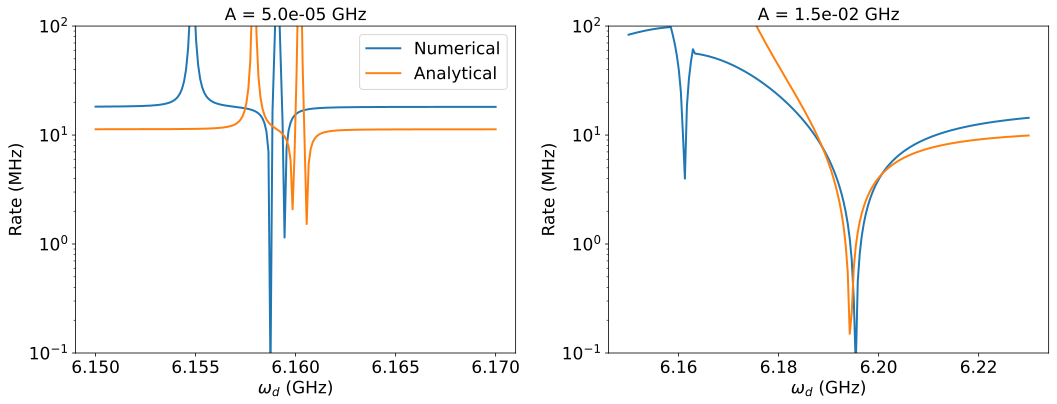

In [316]:
#check approximations
from joblib import Parallel, delayed

Ej = 30.19
Ec = 0.1
omega_c1 = 5.226
omega_c2 = 8.135
phi_ex = 0.2
bare_dim = [10,1,6]
trunc_dim = [5,1,4]
# Define the combinations of parameters to test

# Create a figure with two subplots for different amplitudes
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot - A = 0.5e-4*2*anp.pi
A1 = 0.5e-4*2*anp.pi
omega_ds1 = anp.linspace(6.15, 6.17, 200)*2*anp.pi
phizpf_dependence = True
twolevelapp = False

sc = Hamiltonian(phi_ex, Ej, Ec, bare_dim, trunc_dim, omega_c1, omega_c2, phizpf_dependence, twolevelapp)

# Function to calculate static rate for a given drive frequency
def calculate_static_rate(omegad, amplitude):
    der = sc.approximateder(amplitude, omegad)[1]
    return sc.static_rate(der)

# Function to calculate analytical rate for a given drive frequency
def calculate_analytical_rate(omegad, amplitude):
    return sc.static_rate(sc.der_formula(amplitude, omegad))

# Parallelize the calculations using joblib for first amplitude
static_rates1 = Parallel(n_jobs=-1)(delayed(calculate_static_rate)(omegad, A1) for omegad in omega_ds1)
analytical_rates1 = Parallel(n_jobs=-1)(delayed(calculate_analytical_rate)(omegad, A1) for omegad in omega_ds1)

# Convert to numpy arrays for plotting
static_rates1 = anp.array(static_rates1)
analytical_rates1 = anp.array(analytical_rates1)

# Second subplot - A = 10e-3*2*anp.pi
A2 = 15e-3*2*anp.pi
omega_ds2 = anp.linspace(6.15, 6.23, 200)*2*anp.pi

# Parallelize the calculations using joblib for second amplitude
static_rates2 = Parallel(n_jobs=-1)(delayed(calculate_static_rate)(omegad, A2) for omegad in omega_ds2)
analytical_rates2 = Parallel(n_jobs=-1)(delayed(calculate_analytical_rate)(omegad, A2) for omegad in omega_ds2)

# Convert to numpy arrays for plotting
static_rates2 = anp.array(static_rates2)
analytical_rates2 = anp.array(analytical_rates2)

# Set font sizes for paper-quality figure
plt.rcParams.update({
    'font.size': 17,
    'axes.titlesize': 17,
    'axes.labelsize': 17,
    'xtick.labelsize': 17,
    'ytick.labelsize': 17,
    'legend.fontsize': 17,
    'figure.titlesize': 17
})

# Plot the first subplot
axs[0].plot(omega_ds1/2/anp.pi, static_rates1, label='Numerical', linewidth=2)
axs[0].plot(omega_ds1/2/anp.pi, analytical_rates1, label='Analytical', linewidth=2)
axs[0].set_xlabel('$\omega_d$ (GHz)')
axs[0].set_ylabel('Rate (MHz)')
axs[0].legend()
axs[0].set_yscale('log')
axs[0].set_ylim(1e-1, 100)
axs[0].set_title(f'A = {A1/(2*anp.pi):.1e} GHz')
axs[0].xaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))

# Plot the second subplot
axs[1].plot(omega_ds2/2/anp.pi, static_rates2, label='Numerical', linewidth=2)
axs[1].plot(omega_ds2/2/anp.pi, analytical_rates2, label='Analytical', linewidth=2)
axs[1].set_xlabel('$\omega_d$ (GHz)')
axs[1].set_ylabel('Rate (MHz)')
axs[1].set_yscale('log')
axs[1].set_ylim(1e-1, 100)
axs[1].set_title(f'A = {A2/(2*anp.pi):.1e} GHz')
axs[1].xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

plt.tight_layout()
plt.show()

In [84]:
Ej = 30.19
Ec = 0.1
omega_c1 = 5.226
omega_c2 = 8.135
phi_ex = 0.2
bare_dim = [10,1,6]
trunc_dim = [5,1,4]
sc = Hamiltonian(phi_ex, Ej, Ec, bare_dim, trunc_dim, omega_c1, omega_c2, phizpf_dependence=True, twolevelapp=False)

# Define different amplitudes and frequencies for 2D scan
d = 100
omega_ds_2d = anp.linspace(6.17, 6.2, d)*2*anp.pi  # Drive frequencies in GHz
As_2d = 2*anp.pi*anp.linspace(2e-3, 15e-3, d)  # Drive amplitudes from 1 to 10 mA

# Create meshgrid for 2D plot
omega_mesh, A_mesh = anp.meshgrid(omega_ds_2d, As_2d)
rates_2d = anp.zeros((d, d))
omega_dsolution = anp.zeros((d))
# Import joblib for parallelization
from joblib import Parallel, delayed
# Define a function to compute derivatives at a single point
def compute_derivatives(i, j, A, omegad, sc):
    omega_dpredicted = sc.obtain_omegad(A)
    approx_der = sc.approximateder(A, omegad)[0]
    # Calculate transition rates using static_rate
    return (i, j, omega_dpredicted, approx_der)

# Use joblib to parallelize the computation
results = Parallel(n_jobs=-1)(
    delayed(compute_derivatives)(i, j, A, omegad, sc)
    for i, A in enumerate(As_2d)
    for j, omegad in enumerate(omega_ds_2d)
)

# Process the results
for i, j, omega_dpredicted, approx_der in results:
    rates_2d[i, j] = sc.static_rate(approx_der)
    if j == 0:  # Store omega_dsolution only once per A (for the first frequency)
        omega_dsolution[i] = omega_dpredicted




 /tmp/ipykernel_4112743/3034003196.py: 39

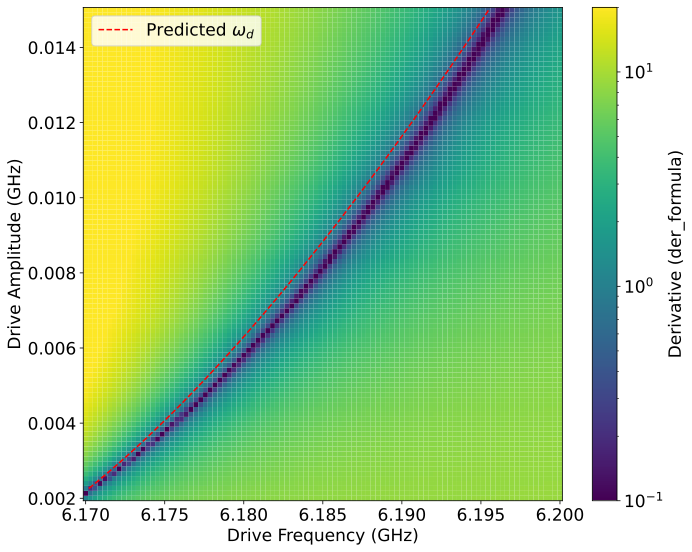

In [88]:
# Create 2D plot
fig, ax = plt.subplots(figsize=(10, 8))

# Import matplotlib for colors
import matplotlib.colors

# Plot der_formula results with log scale colorbar
im = ax.pcolormesh(omega_mesh / (2 * anp.pi), A_mesh / (2 * anp.pi), rates_2d, shading='auto', cmap='viridis',
                   norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=20))
cbar = fig.colorbar(im, ax=ax, label='Derivative (der_formula)')
ax.set_xlabel('Drive Frequency (GHz)')
ax.set_ylabel('Drive Amplitude (GHz)')

# Remove the grid
ax.grid(False)

# Plot the dashed line only where omega_dsolution / (2 * anp.pi) > omega_mesh / (2 * anp.pi)
mask = omega_dsolution / (2 * anp.pi) > omega_mesh[:, 0] / (2 * anp.pi)
ax.plot(omega_dsolution[mask] / (2 * anp.pi), As_2d[mask] / (2 * anp.pi), 'r--', label='Predicted $\omega_d$')

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


In [373]:
Ej = 30.19
Ec = 0.1
omega_c1 = 5.226
omega_c2 = 8.135
phi_ex = 0.2
bare_dim = [10,1,6]
trunc_dim = [5,1,4]

# Import joblib for parallelization
from joblib import Parallel, delayed

# Define different amplitudes
amplitudes = [15e-3*2*anp.pi, 1e-3*2*anp.pi]
sc = Hamiltonian(phi_ex, Ej, Ec, bare_dim, trunc_dim, omega_c1, omega_c2, phizpf_dependence=True, twolevelapp=False)

# Define a function to process a single frequency
def process_frequency(A, omegad):
    der = sc.approximateder(A, omegad)
    # Convert tuple to list to allow item assignment
    der_list = anp.array(der)
    der_list[2] = der_list[2] - der_list[1]
    der_list[1] = der_list[1] - der_list[0]
    return sc.static_rate(der_list)

# Process frequencies in parallel for each amplitude
rates = []

# First amplitude with frequency range 6.18-6.22
omega_ds_1 = anp.linspace(6.18, 6.22, 100)*2*anp.pi
A_rates = Parallel(n_jobs=-1)(delayed(process_frequency)(amplitudes[0], omegad) for omegad in omega_ds_1)
rates.append(A_rates)

# Second amplitude with frequency range 6.16-6.18
omega_ds_2 = anp.linspace(6.16, 6.18, 100)*2*anp.pi
A_rates = Parallel(n_jobs=-1)(delayed(process_frequency)(amplitudes[1], omegad) for omegad in omega_ds_2)
rates.append(A_rates)

rates = anp.array(rates)  # Shape will be (2, 100, 3)

ValueError: x and y must have same first dimension, but have shapes (200,) and (100,)

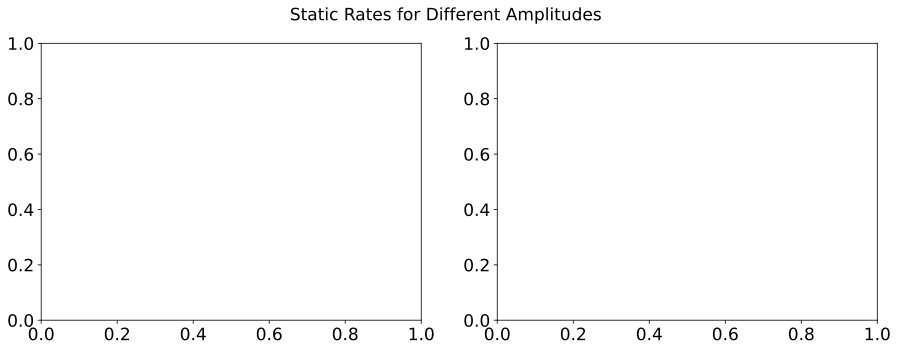

In [374]:
# Create a figure with 3 subplots (one for each transition)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Static Rates for Different Amplitudes')

# Plot each transition in a separate subplot
for i in range(3):  # For each transition
    for j, A in enumerate(amplitudes):  # For each amplitude
        label = f'A = {A/(2*anp.pi):.1e} GHz'
        # rates shape is (2, 30, 3): [amplitude, frequency, transition]
        axs[j].plot(omega_ds/(2*anp.pi), rates[j, :, i], label=label if i == 0 else None)
        axs[j].set_yscale('log')
    axs[j].set_xlabel('Drive Frequency (GHz)')
    axs[j].set_ylabel('Static Rate (Hz)')
    axs[j].set_title(f'Transition {i}')
    
    axs[j].grid(True)

# Only add legend to the first subplot
axs[0].legend()
plt.tight_layout()
plt.show()

In [376]:
Ej = 30.19
Ec = 0.1
omega_c1 = 5.226
omega_c2 = 8.135
phi_ex = 0.2
bare_dim = [10,6,6]
trunc_dim = [5,4,4]
sc = Hamiltonian(phi_ex, Ej, Ec, bare_dim, trunc_dim, omega_c1, omega_c2, phizpf_dependence=True, twolevelapp=False)
A = 10e-3*2*anp.pi
omega_d = 6.21*2*anp.pi
sc.approximateder(A, omega_d)

(array(-0.11465494), array(-0.33452484))

In [380]:
Ej = 30.19
Ec = 0.1
omega_c1 = 5.226
omega_c2 = 8.135
phi_ex = 0.2
bare_dim = [10,6,6]
trunc_dim = [5,4,4]
sc = Hamiltonian(phi_ex, Ej, Ec, bare_dim, trunc_dim, omega_c1, omega_c2, phizpf_dependence=True, twolevelapp=False)

# Define amplitude and frequency range
A = 10e-3*2*anp.pi
omega_ds = anp.linspace(6.15, 6.23, 50)*2*anp.pi

# Function to calculate static rate for a given drive frequency
def calculate_static_rate(omegad, amplitude):
    der = anp.array(sc.approximateder(amplitude, omegad))
    return sc.static_rate(der)

# Parallelize the calculations using joblib
static_rates = Parallel(n_jobs=-1)(delayed(calculate_static_rate)(omegad, A) for omegad in omega_ds)

# Convert to numpy arrays for plotting
static_rates = anp.array(static_rates)

 /opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/autograd/tracer.py: 14UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
 /opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py: 752UserWarning: Output seems independent of input.
 /opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/autograd/tracer.py: 14

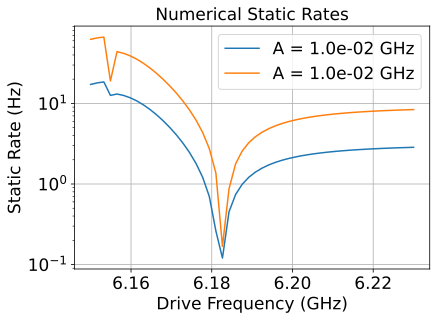

In [381]:
# Create a figure with two subplots
fig, axs = plt.subplots( )

# Plot static rates
axs.plot(omega_ds/(2*anp.pi), static_rates, label=f'A = {A/(2*anp.pi):.1e} GHz')
axs.set_xlabel('Drive Frequency (GHz)')
axs.set_ylabel('Static Rate (Hz)')
axs.set_title('Numerical Static Rates')
axs.set_yscale('log')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()